** Brian Blaylock **
** January 16, 2019 **

# HRRR values for GLM Flashes

- What is the model conditions at each flash location?
- How does that value compare to the typical (OSG Climatology) conditions?

In [32]:
import xarray
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
import os

import sys
sys.path.append('/uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v3')
from BB_HRRR.HRRR_Pando import get_hrrr_latlon, pluck_hrrr_point, get_hrrr_variable
from BB_HRRR.HRRR_Spread import spread
from BB_maps.my_basemap import draw_centermap, draw_HRRR_map
from BB_cmap.NWS_standard_cmap import *
from BB_cmap.reflectivity_cmap import reflect_ncdc
from BB_datetimes.range import range_dates
from BB_GOES.get_GLM import get_GLM_file_nearesttime

In [2]:
m = draw_HRRR_map()

In [3]:
DATE = datetime(2018, 8, 4)

In [4]:
bounding_box = []

In [5]:
# Load a HRRR file
H = get_hrrr_variable(DATE, 'UVGRD:10 m', verbose=False)
#Hland = get_hrrr_variable(DATE, 'LAND:surface', verbose=False)

In [76]:
fxx = range(0,19)
Hrefc = [get_hrrr_variable(DATE-timedelta(hours=f), 'REFC:entire', verbose=False, fxx=f, value_only=True)['value'] for f in fxx]
Hltng = [get_hrrr_variable(DATE-timedelta(hours=f), 'LTNG:entire', verbose=False, fxx=f, value_only=True)['value'] for f in fxx]

In [77]:
Huv10 = [get_hrrr_variable(DATE-timedelta(hours=f), 'UVGRD:10 m', verbose=False, fxx=f, value_only=True)['SPEED'] for f in fxx]

In [7]:
GLM_FILES = get_GLM_file_nearesttime(datetime(2018, 8, 4), window=30)

Looking in these file paths for th nearest datetime
/uufs/chpc.utah.edu/common/home/horel-group7/Pando/GOES16/GLM-L2-LCFA/20180803/23/
/uufs/chpc.utah.edu/common/home/horel-group7/Pando/GOES16/GLM-L2-LCFA/20180804/00/
/uufs/chpc.utah.edu/common/home/horel-group7/Pando/GOES16/GLM-L2-LCFA/20180804/01/
       requested: 2018-08-04 00:00:00
nearest GLM file: 2018-08-04 00:00:00
        GLM file: /uufs/chpc.utah.edu/common/home/horel-group7/Pando/GOES16/GLM-L2-LCFA/20180804/00/OR_GLM-L2-LCFA_G16_s20182160000000_e20182160000200_c20182160000227.nc
window = 30 files (+/- 10.0 minutes)
returning 61 files


In [8]:
# Open all the files for the ABI scan
dd = {}
for i, file in enumerate(GLM_FILES):
    dd[i] = xarray.open_dataset(file)

In [9]:
# Concatenate all the files for variables I want along the dimension "number_of_flashes"
flash_lon = xarray.concat([dd[i].flash_lon for i in dd.keys()], dim='number_of_flashes')
flash_lat = xarray.concat([dd[i].flash_lat for i in dd.keys()], dim='number_of_flashes')
flash_area = xarray.concat([dd[i].flash_area for i in dd.keys()], dim='number_of_flashes')
flash_id = xarray.concat([dd[i].flash_id for i in dd.keys()], dim='number_of_flashes')
flash_energy = xarray.concat([dd[i].flash_energy for i in dd.keys()], dim='number_of_flashes')
flash_quality_flag = xarray.concat([dd[i].flash_quality_flag for i in dd.keys()], dim='number_of_flashes')

flash_time_offset_of_first_event = xarray.concat([dd[i].flash_time_offset_of_first_event for i in dd.keys()], dim='number_of_flashes')
flash_time_offset_of_last_event = xarray.concat([dd[i].flash_time_offset_of_last_event for i in dd.keys()], dim='number_of_flashes')

group_parent_flash_id = xarray.concat([dd[i].group_parent_flash_id for i in dd.keys()], dim='number_of_groups')

/uufs/chpc.utah.edu/common/home/u0553130/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:916: UserWarning: Warning: converting a masked element to nan.
  dtype = np.min_scalar_type(value)
/uufs/chpc.utah.edu/common/home/u0553130/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:716: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


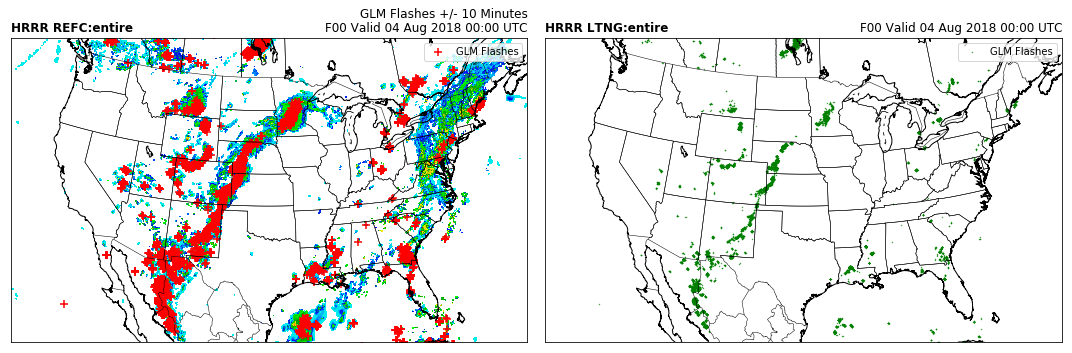

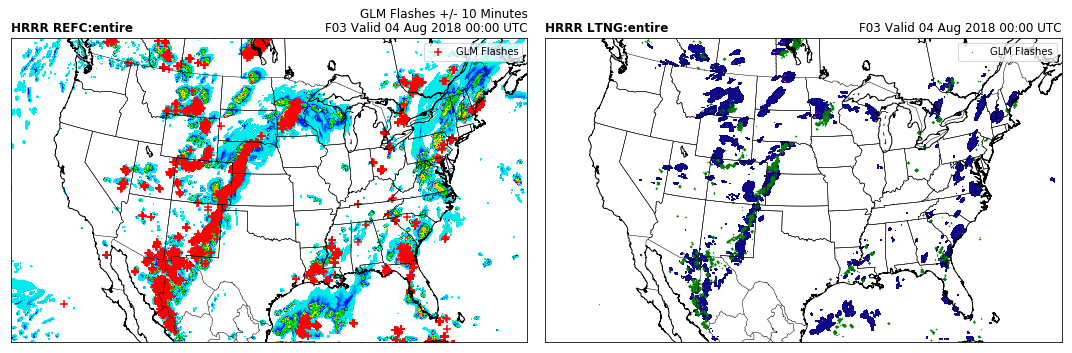

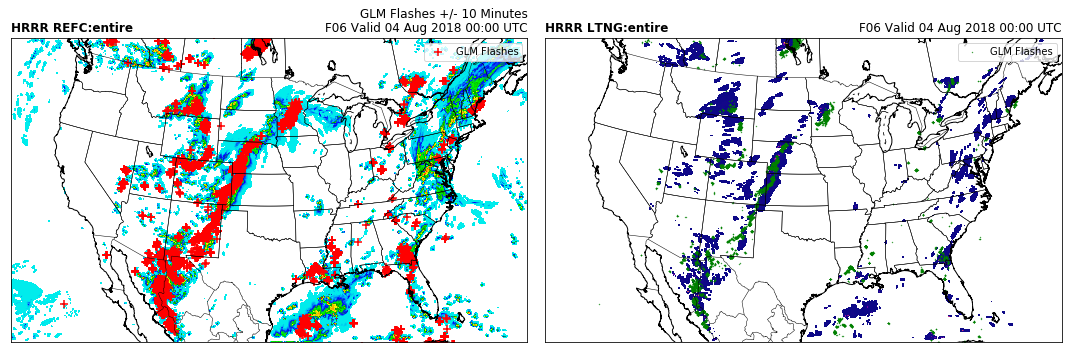

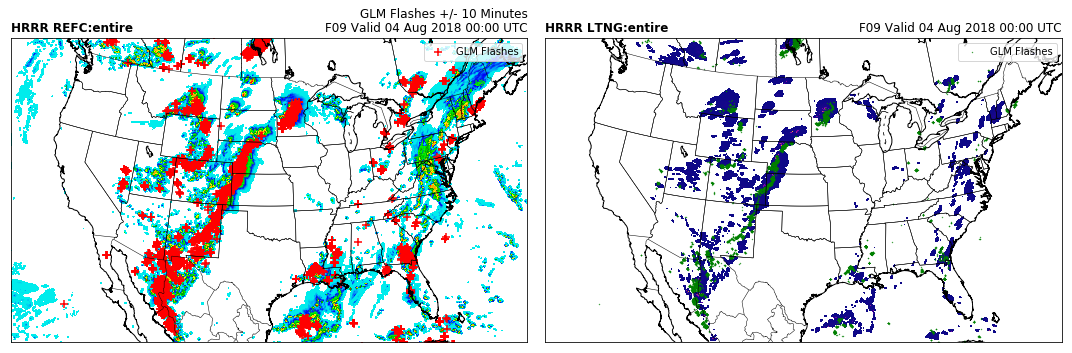

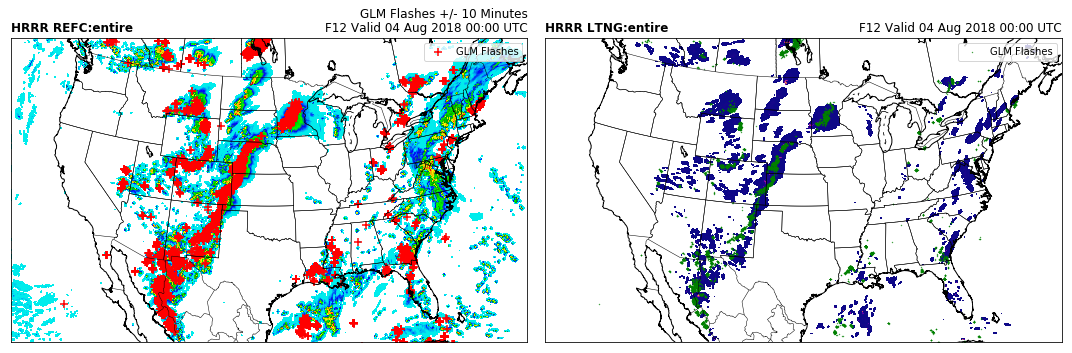

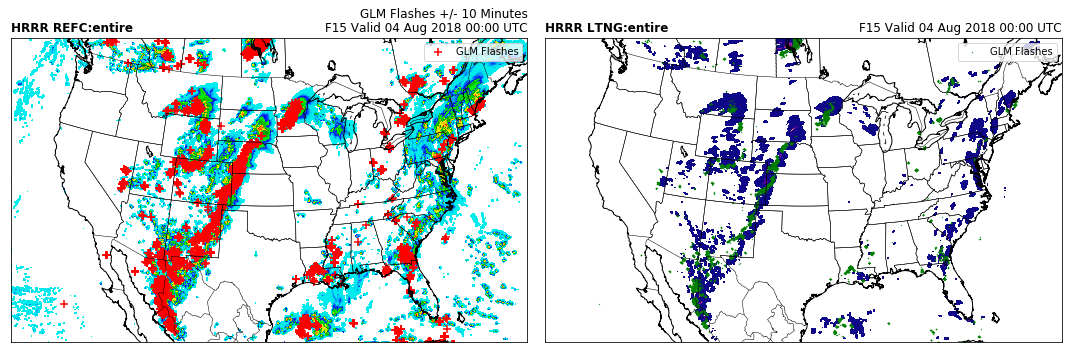

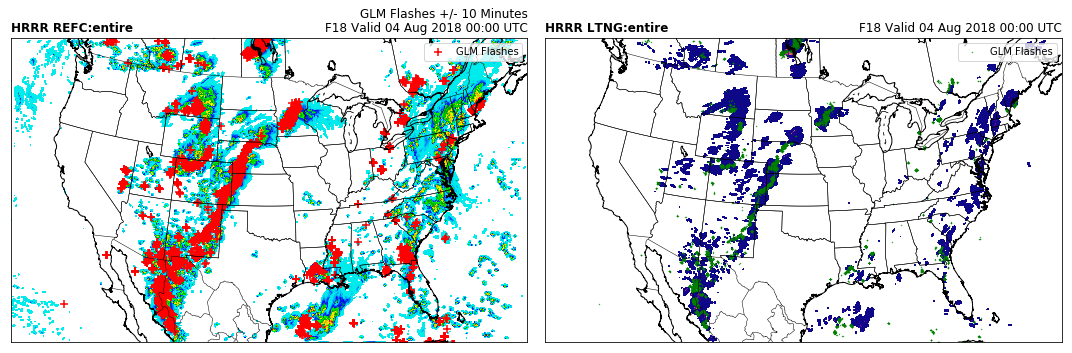

In [31]:
c = reflect_ncdc()
for i, f in enumerate(fxx):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
        
    plt.sca(ax1)
    m.pcolormesh(H['lon'], H['lat'], Hrefc[i],
                 cmap=c['cmap'], vmax=c['vmax'], vmin=c['vmin'], latlon=True)
    m.scatter(flash_lon.data, flash_lat.data,
              marker='+', color='red', s=50,
              latlon=True, label="GLM Flashes")
    m.drawstates()
    m.drawcountries()
    m.drawcoastlines()
    plt.title('HRRR REFC:entire', loc='left', fontweight='semibold')
    plt.title('GLM Flashes +/- 10 Minutes\nF%02d Valid %s' % (f, (DATE).strftime('%d %b %Y %H:%M UTC')), loc='right')
    plt.legend()
    
    plt.sca(ax2)
    m.pcolormesh(H['lon'], H['lat'], Hltng[i], cmap='plasma', latlon=True)
    m.scatter(flash_lon.data, flash_lat.data,
              marker='.', color='green', s=.5,
              latlon=True, label='GLM Flashes')
    m.drawstates()
    m.drawcountries()
    m.drawcoastlines()
    plt.title('HRRR LTNG:entire', loc='left', fontweight='semibold')
    plt.title('F%02d Valid %s' % (f, (DATE).strftime('%d %b %Y %H:%M UTC')), loc='right')
    plt.legend()
    
    fig.tight_layout()
    
    plt.savefig('./F%02d_GLM-HRRR' % f, bbox_inches='tight')

# Model Spread and Lightning

In [69]:
# Don't compute standard devation on masked array,
# Set the masked values to zero, then compute model spread.
Hrefc_2 = np.array([i.data for i in Hrefc])
Hrefc_2[Hrefc_2<0] = 0

In [71]:
# Since there is no lightning data for F00, don't include it!
Hltng_2 = np.array([i.data for i in Hltng[1:]])
Hltng_2[Hltng_2<0] = 0

/uufs/chpc.utah.edu/common/home/u0553130/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:138: RuntimeWarning: invalid value encountered in sqrt
  ret = um.sqrt(ret, out=ret)


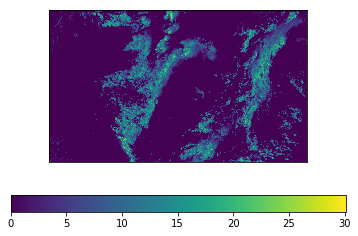

In [65]:
m.pcolormesh(H['lon'], H['lat'], np.std(Hrefc_2, ddof=1, axis=0), latlon=True)
plt.colorbar(orientation='horizontal')

/uufs/chpc.utah.edu/common/home/u0553130/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:138: RuntimeWarning: invalid value encountered in sqrt
  ret = um.sqrt(ret, out=ret)


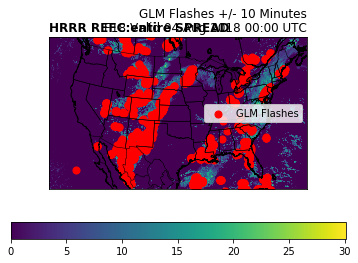

In [78]:
plt.figure(figsize=(10,5))
m.pcolormesh(H['lon'], H['lat'], np.std(Hrefc_2, ddof=1, axis=0), latlon=True)
plt.colorbar(orientation='horizontal')
m.scatter(flash_lon.data, flash_lat.data,
          marker='o', color='red', s=50,
          latlon=True, label="GLM Flashes")
m.drawstates()
m.drawcountries()
m.drawcoastlines()
plt.title('HRRR REFC:entire SPREAD', loc='left', fontweight='semibold')
plt.title('GLM Flashes +/- 10 Minutes\nF%02d Valid %s' % (f, (DATE).strftime('%d %b %Y %H:%M UTC')), loc='right')
plt.legend()
fig.tight_layout()

plt.savefig('./Fxx_GLM-HRRR_SPREAD_refc', bbox_inches='tight')

No handles with labels found to put in legend.


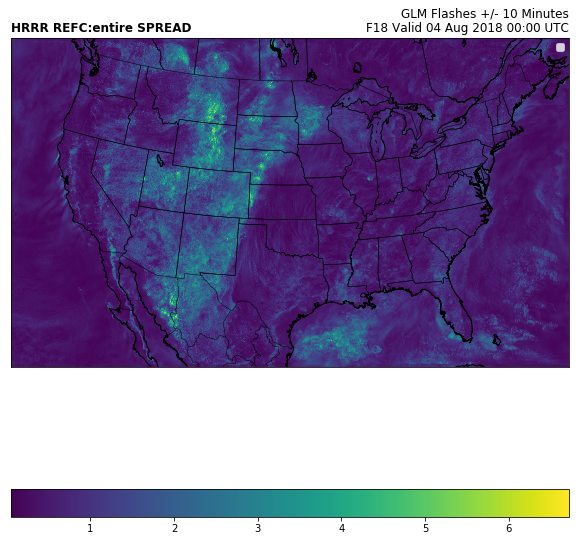

In [82]:
plt.figure(figsize=(10,15))

m.pcolormesh(H['lon'], H['lat'], np.std(Huv10, ddof=1, axis=0), latlon=True)
plt.colorbar(orientation='horizontal')

#m.scatter(flash_lon.data, flash_lat.data,
#          marker='.', color='red', s=1,
#          latlon=True, label="GLM Flashes")
m.drawstates()
m.drawcountries()
m.drawcoastlines()
plt.title('HRRR REFC:entire SPREAD', loc='left', fontweight='semibold')
plt.title('GLM Flashes +/- 10 Minutes\nF%02d Valid %s' % (f, (DATE).strftime('%d %b %Y %H:%M UTC')), loc='right')
plt.legend()
fig.tight_layout()

plt.savefig('./Fxx_GLM-HRRR_SPREAD_uvgrd10', bbox_inches='tight')